<a href="https://colab.research.google.com/github/AndrewBoessen/CSCI3387_Notebooks/blob/main/Copy_of_Skiing_Rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup gym env
!pip install gymnasium<1.0.0
!pip install "gymnasium[atari, accept-rom-license]<1.0.0"
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
from IPython.display import HTML
from base64 import b64encode

/bin/bash: line 1: 1.0.0: No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.7 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=97a027f1935e68a2a1d62ebbe0f6a62cda81be67dc1f850e5b1f1db377bae2a1
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0
  Attempting uninstall: ale-py
    Found existing installation: a

In [ ]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


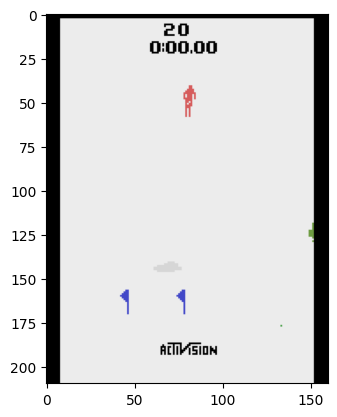

In [ ]:
env = gym.make('ALE/Skiing-v5', render_mode="rgb_array")
# Wrap the environment with RecordVideo
# env = RecordVideo(env, "videos", episode_trigger=lambda x: x % 1 == 0)

# Reset the environment to get the initial observation
observation, info = env.reset()

# Render the initial observation
plt.imshow(observation)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Deep Q Network
#
# This model is used to approximate the Q function

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[2], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the size of the output from the convolutional layers
        conv_out_size = self._get_conv_out_size(input_shape)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out_size(self, shape):
        o = self.features(torch.zeros(shape[2], shape[0], shape[1]))
        return int(torch.prod(torch.tensor(o.size()))) # Get size of flattened vector

    def forward(self, x):
        x = x.permute(0, 3, 1, 2) # Permute to (batch_size, channels, height, width)
        features = self.features(x)
        return self.fc(features)

In [ ]:
# Defining memory class for experience replay
from collections import deque
import random

class ReplayMemory(): # Deque containing some past experience where experience is a tuple (state,action,new_state,reward,terminated)
  def __init__(self, maxlen):
    self.memory = deque([],maxlen)

  def append(self, experience): #add experience to deque
    self.memory.append(experience)

  def sample(self, batch_size):  #return a random sample of experience, useful to ensure non correlation as experience is time-correlated
    return random.sample(self.memory, batch_size)

  def __len__(self): #returns length of deque
    return len(self.memory)

In [ ]:
class SkiingDQL():
  #Hyperparameter: turn this into function arg later
  lr = 0.0001
  discount_factor = 0.99
  network_sync_rate = 1000 #number of steps agent takes before we sync the policy and target networks
  replay_memory_size = 100000
  mini_batch_size = 64 #refers to size of batch sampled from replay memory

  env = gym.make('ALE/Skiing-v5', render_mode="rgb_array")
  num_states = env.observation_space.shape
  num_actions =3
  input_space = env.observation_space.shape

   #Create the two networks
  policy_network = DQN(input_space, num_actions).to(device)
  target_network = DQN(input_space, num_actions).to(device)

  loss = nn.MSELoss()
  optimizer = torch.optim.Adam(policy_network.parameters())

  ACTIONS = ["Left","Right","No_Action"]

  def optimize(self,mini_batch,policy_network,target_network):

    current_q_list = []
    target_q_list = []

    ##optimize policy network
    self.optimizer.zero_grad()

    states,actions,new_states,rewards,terminated = zip(*mini_batch)

    states = torch.stack([torch.from_numpy(arr.astype(np.float32) / 255.0) for arr in states]).to(device)
    new_states = torch.stack([torch.from_numpy(arr.astype(np.float32) / 255.0) for arr in new_states]).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    terminated = torch.tensor(terminated, dtype=torch.bool).to(device)

    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

    # Calculate target Q-values
    with torch.no_grad():
        next_q_values = target_network(new_states)
        max_next_q_values = next_q_values.max(1)[0]
        targets = rewards + (1 - terminated.float()) * self.discount_factor * max_next_q_values

    # Get current Q-values
    current_q_values = policy_network(states)
    current_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

    # Compute loss
    loss = self.loss(current_q_values, targets)

    # Backpropagation and optimization
    loss.backward()
    self.optimizer.step()

  def train(self, episodes):


    epsilon = 0.999 #
    memory = ReplayMemory(self.replay_memory_size) #creating memory of experience



    self.target_network.load_state_dict(self.policy_network.state_dict()) #Copying the weights so that the networks are the same

    rewards_per_episode = np.zeros(episodes)
    epsilon_decays = []
    step_count = 0
    total_steps = 0
    # Create progress bar for episodes
    with tqdm(total=episodes, desc="Training Progress") as pbar:
        for i in range(episodes):
            state, _ = self.env.reset()
            terminated = False
            truncated = False
            episode_steps = 0
            # Create progress bar for steps within an episode
            with tqdm(total=None, desc=f"Episode {i+1}", leave=False) as episode_pbar:
                while not terminated and not truncated:
                    if random.random() < epsilon:
                        action = self.env.action_space.sample()
                    else:
                        with torch.no_grad():
                            state_t = torch.tensor(state, dtype=torch.float32).to(device) /255.0
                            state_t = torch.unsqueeze(state_t, 0)
                            action = self.policy_network(state_t).argmax().item()
                    new_state, reward, terminated, truncated, _ = self.env.step(action)
                    memory.append((state, action, new_state, reward, terminated))
                    state = new_state
                    step_count += 1
                    total_steps += 1
                    episode_steps += 1
                    rewards_per_episode[i] += reward
                    if len(memory) > self.mini_batch_size:
                        mini_batch = memory.sample(self.mini_batch_size)
                        self.optimize(mini_batch, self.policy_network, self.target_network)
                        epsilon = max(epsilon - (1 / (episodes * 1000)), 0.01)
                        epsilon_decays.append(epsilon)
                        if step_count > self.network_sync_rate:
                            self.target_network.load_state_dict(self.policy_network.state_dict())
                            step_count = 0
                    # Update episode progress bar
                    episode_pbar.update(1)
                    episode_pbar.set_postfix({"Reward": f"{rewards_per_episode[i]:.2f}", "Epsilon": f"{epsilon:.2f}"})
                    if terminated or truncated:
                      break
            # Update main progress bar
            pbar.update(1)
            pbar.set_postfix({"Total Steps": total_steps, "Avg Reward": f"{np.mean(rewards_per_episode[:i+1]):.2f}"})
            # Small delay to allow for visual updates
            time.sleep(0.1)
    print(f"Total reward: {np.sum(rewards_per_episode)}")
    print(f"Average reward per episode: {np.mean(rewards_per_episode)}")

In [ ]:
agent = SkiingDQL()
agent.train(episodes=100)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Episode 1: 0it [00:00, ?it/s]

Episode 2: 0it [00:00, ?it/s]

Episode 3: 0it [00:00, ?it/s]

Episode 4: 0it [00:00, ?it/s]

Episode 5: 0it [00:00, ?it/s]

Episode 6: 0it [00:00, ?it/s]

Episode 7: 0it [00:00, ?it/s]

Episode 8: 0it [00:00, ?it/s]

Episode 9: 0it [00:00, ?it/s]

Episode 10: 0it [00:00, ?it/s]

Episode 11: 0it [00:00, ?it/s]

Episode 12: 0it [00:00, ?it/s]

Episode 13: 0it [00:00, ?it/s]

Episode 14: 0it [00:00, ?it/s]

Episode 15: 0it [00:00, ?it/s]

Episode 16: 0it [00:00, ?it/s]

Episode 17: 0it [00:00, ?it/s]

Episode 18: 0it [00:00, ?it/s]

Episode 19: 0it [00:00, ?it/s]

Episode 20: 0it [00:00, ?it/s]

Episode 21: 0it [00:00, ?it/s]

Episode 22: 0it [00:00, ?it/s]

Episode 23: 0it [00:00, ?it/s]

Episode 24: 0it [00:00, ?it/s]

Episode 25: 0it [00:00, ?it/s]

Episode 26: 0it [00:00, ?it/s]

Episode 27: 0it [00:00, ?it/s]

Episode 28: 0it [00:00, ?it/s]

Episode 29: 0it [00:00, ?it/s]

Episode 30: 0it [00:00, ?it/s]

Episode 31: 0it [00:00, ?it/s]

Episode 32: 0it [00:00, ?it/s]

Episode 33: 0it [00:00, ?it/s]

Episode 34: 0it [00:00, ?it/s]

Episode 35: 0it [00:00, ?it/s]

Episode 36: 0it [00:00, ?it/s]

Episode 37: 0it [00:00, ?it/s]

Episode 38: 0it [00:00, ?it/s]

Episode 39: 0it [00:00, ?it/s]

Episode 40: 0it [00:00, ?it/s]

Episode 41: 0it [00:00, ?it/s]

Episode 42: 0it [00:00, ?it/s]

Episode 43: 0it [00:00, ?it/s]

Episode 44: 0it [00:00, ?it/s]

Episode 45: 0it [00:00, ?it/s]

Episode 46: 0it [00:00, ?it/s]

Episode 47: 0it [00:00, ?it/s]

Episode 48: 0it [00:00, ?it/s]

Episode 49: 0it [00:00, ?it/s]

Episode 50: 0it [00:00, ?it/s]

Episode 51: 0it [00:00, ?it/s]

Episode 52: 0it [00:00, ?it/s]

Episode 53: 0it [00:00, ?it/s]

Episode 54: 0it [00:00, ?it/s]

Episode 55: 0it [00:00, ?it/s]

Episode 56: 0it [00:00, ?it/s]

Episode 57: 0it [00:00, ?it/s]

Episode 58: 0it [00:00, ?it/s]

Episode 59: 0it [00:00, ?it/s]

Episode 60: 0it [00:00, ?it/s]

Episode 61: 0it [00:00, ?it/s]

Episode 62: 0it [00:00, ?it/s]

Episode 63: 0it [00:00, ?it/s]

Episode 64: 0it [00:00, ?it/s]

Episode 65: 0it [00:00, ?it/s]

Episode 66: 0it [00:00, ?it/s]

Episode 67: 0it [00:00, ?it/s]

Episode 68: 0it [00:00, ?it/s]

Episode 69: 0it [00:00, ?it/s]

Episode 70: 0it [00:00, ?it/s]

Episode 71: 0it [00:00, ?it/s]

Episode 72: 0it [00:00, ?it/s]

Episode 73: 0it [00:00, ?it/s]

Episode 74: 0it [00:00, ?it/s]

Episode 75: 0it [00:00, ?it/s]

Episode 76: 0it [00:00, ?it/s]

Episode 77: 0it [00:00, ?it/s]

Episode 78: 0it [00:00, ?it/s]

Episode 79: 0it [00:00, ?it/s]

Episode 80: 0it [00:00, ?it/s]

Episode 81: 0it [00:00, ?it/s]

Episode 82: 0it [00:00, ?it/s]

Episode 83: 0it [00:00, ?it/s]

Episode 84: 0it [00:00, ?it/s]

Episode 85: 0it [00:00, ?it/s]

Episode 86: 0it [00:00, ?it/s]

Episode 87: 0it [00:00, ?it/s]

Episode 88: 0it [00:00, ?it/s]

Episode 89: 0it [00:00, ?it/s]

Episode 90: 0it [00:00, ?it/s]

Episode 91: 0it [00:00, ?it/s]

Episode 92: 0it [00:00, ?it/s]

Episode 93: 0it [00:00, ?it/s]

Episode 94: 0it [00:00, ?it/s]

Episode 95: 0it [00:00, ?it/s]

Episode 96: 0it [00:00, ?it/s]

Episode 97: 0it [00:00, ?it/s]

Episode 98: 0it [00:00, ?it/s]

Episode 99: 0it [00:00, ?it/s]

Episode 100: 0it [00:00, ?it/s]

Total reward: -1950016.0
Average reward per episode: -19500.16


In [ ]:
from IPython.display import HTML
from IPython import display
import base64
from gym.wrappers import RecordVideo

def run_episode_with_model(model, env_name, device):
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, "video", episode_trigger=lambda x: True)

    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device) / 255.0
        with torch.no_grad():
            action = model(state_tensor).argmax().item()

        state, reward, terminated, _ = env.step(action)
        total_reward += reward
        done = terminated

    env.close()
    return total_reward

def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Run an episode and record video
model = agent.policy_network
env_name = "ALE/Skiing-v5"

model.eval()

total_reward = run_episode_with_model(model, env_name, device)
print(f"Total reward: {total_reward}")

# Display the video
video_path = "video/rl-video-episode-0.mp4"
display.display(show_video(video_path))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWa

Total reward: -30245.0


In [ ]:
batch_size = 1
height = 210
width = 160
channels = 3
num_actions = 3
random_obs= env.observation_space.sample()

sample_input = torch.rand(batch_size, height, width, channels)
model = DQN(input_shape=(height, width, channels), num_actions=num_actions)

output = model(torch.unsqueeze(torch.tensor(random_obs, dtype=torch.float32),0))

print(output)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[0.8903, 1.4028, 0.6234]], grad_fn=<AddmmBackward0>)
